In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.rich import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

# Đọc dữ liệu

## Movies

In [2]:
movies_df = pd.read_csv("/kaggle/input/movielens-1m-dataset/movies.dat", 
                        header = None, 
                        sep='::', 
                        names=['MovieID', 'Title', 'Genre'],
                        engine='python',
                        encoding='latin-1')
movies_df.head()

,MovieID,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies_df['Year'] = movies_df['Title'].apply(lambda x: int(x[-5: -1]))
movies_df['Name'] = movies_df['Title'].apply(lambda x: x[: -7])
movies_df.drop(columns=['Title'], inplace=True)
movies_df.head()

,MovieID,Genre,Year,Name
0,1,Animation|Children's|Comedy,1995,Toy Story
1,2,Adventure|Children's|Fantasy,1995,Jumanji
2,3,Comedy|Romance,1995,Grumpier Old Men
3,4,Comedy|Drama,1995,Waiting to Exhale
4,5,Comedy,1995,Father of the Bride Part II


In [4]:
genres_raw  = movies_df['Genre'].str.split('|', expand=True)
genres_raw.head()

,0,1,2,3,4,5
0,Animation,Children's,Comedy,None,None,None
1,Adventure,Children's,Fantasy,None,None,None
2,Comedy,Romance,None,None,None,None
3,Comedy,Drama,None,None,None,None
4,Comedy,None,None,None,None,None


In [5]:
list_genres = []
for i in range(6):
    list_genres += genres_raw[i].tolist()
set_genres = set(list_genres)
set_genres.remove(None)
set_genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [6]:
for genre in set_genres:
    movies_df[genre] = movies_df['Genre'].apply(lambda x: 1 if genre in x else 0)
movies_df.drop(columns=['Genre'], inplace=True)
movies_df.head()

,MovieID,Year,Name,Sci-Fi,Mystery,Horror,War,Thriller,Fantasy,Film-Noir,...,Documentary,Comedy,Animation,Western,Children's,Action,Adventure,Romance,Drama,Musical
0,1,1995,Toy Story,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
1,2,1995,Jumanji,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
2,3,1995,Grumpier Old Men,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,4,1995,Waiting to Exhale,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,5,1995,Father of the Bride Part II,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Rating

In [8]:
ratings_df = pd.read_csv("/kaggle/input/movielens-1m-dataset/ratings.dat", 
                        header = None, 
                        sep='::', 
                        names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        engine='python',
                        encoding='latin-1')
# rating_mean = ratings_df['Rating'].mean()
# rating_max = ratings_df['Rating'].max()
# rating_min = ratings_df['Rating'].min()
# ratings_df['Rating'] = ratings_df['Rating'].apply(lambda x: (x-rating_mean)/(rating_max - rating_min))
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Users

In [9]:
users_df = pd.read_csv("/kaggle/input/movielens-1m-dataset/users.dat", 
                       sep='::', 
                       header=None, 
                       names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], 
                       engine='python', 
                       encoding='latin-1')
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Nối các bảng lại

In [10]:
colab_df = pd.merge(ratings_df, users_df, on='UserID', how='inner')
colab_df

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067
...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106
1000205,6040,1094,5,956704887,M,25,6,11106
1000206,6040,562,5,956704746,M,25,6,11106
1000207,6040,1096,4,956715648,M,25,6,11106


In [11]:
merged_df = pd.merge(colab_df, movies_df, on='MovieID', how='inner')
merged_df 

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Year,Name,...,Documentary,Comedy,Animation,Western,Children's,Action,Adventure,Romance,Drama,Musical
0,1,1193,5,978300760,F,1,10,48067,1975,One Flew Over the Cuckoo's Nest,...,0,0,0,0,0,0,0,0,1,0
1,1,661,3,978302109,F,1,10,48067,1996,James and the Giant Peach,...,0,0,1,0,1,0,0,0,0,1
2,1,914,3,978301968,F,1,10,48067,1964,My Fair Lady,...,0,0,0,0,0,0,0,1,0,1
3,1,3408,4,978300275,F,1,10,48067,2000,Erin Brockovich,...,0,0,0,0,0,0,0,0,1,0
4,1,2355,5,978824291,F,1,10,48067,1998,"Bug's Life, A",...,0,1,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106,1989,Weekend at Bernie's,...,0,1,0,0,0,0,0,0,0,0
1000205,6040,1094,5,956704887,M,25,6,11106,1992,"Crying Game, The",...,0,0,0,0,0,0,0,1,1,0
1000206,6040,562,5,956704746,M,25,6,11106,1995,Welcome to the Dollhouse,...,0,1,0,0,0,0,0,0,1,0
1000207,6040,1096,4,956715648,M,25,6,11106,1982,Sophie's Choice,...,0,0,0,0,0,0,0,0,1,0


# Chia train,test

In [12]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Chuẩn bị dữ liệu cho Surprise
reader = Reader(line_format="user item rating")
data = Dataset.load_from_df(ratings_df[["UserID",	"MovieID",	"Rating"]], reader)

# Chia dữ liệu thành tập train và test (80-20)
trainset, testset = train_test_split(data, test_size=0.2)

In [13]:
results = dict()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_actual_vs_predicted(y_true, y_pred, model_name):
    """
    Vẽ biểu đồ so sánh giá trị thực tế (Actual) và giá trị dự đoán (Predicted)
    
    Args:
        y_true (list): Danh sách giá trị thực tế
        y_pred (list): Danh sách giá trị dự đoán
        model_name (str): Tên của mô hình
    """
    sns.regplot(
        x=y_true, 
        y=y_pred, 
        scatter_kws={"s": 10, "color": "green", "alpha": 0.1},  # Chỉnh sửa alpha hợp lệ
        line_kws={"color": "red", "alpha": 0.5}  # Đã sửa lỗi chính tả 'appha' -> 'alpha'
    )
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(f"Actual vs Predicted Ratings ({model_name})")
    plt.show()

# ALS (dùng ở lần trước)

In [15]:
!pip install implicit

In [16]:
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.sparse as sparse


# Chuyển đổi dữ liệu thành ma trận thưa
ratings_matrix = sparse.csr_matrix((ratings_df["Rating"], (ratings_df["UserID"] - 1, ratings_df["MovieID"] - 1)))

# Huấn luyện mô hình ALS
als = AlternatingLeastSquares(factors=50, regularization=0.1)
als.fit(ratings_matrix)

# Dự đoán trên tập test
y_true = []
y_pred_als = []

for uid, iid, true_r in testset:
    y_true.append(true_r)
    
    # Dự đoán bằng cách lấy dot product của vector người dùng và sản phẩm
    user_vecs = als.user_factors[uid - 1]
    item_vecs = als.item_factors[iid - 1]
    y_pred_als.append(np.dot(user_vecs, item_vecs))

# Tính toán lỗi
rmse_als = math.sqrt(mean_squared_error(y_true, y_pred_als))
mae_als = mean_absolute_error(y_true, y_pred_als)
mse_als = mean_squared_error(y_true, y_pred_als)

# Lưu kết quả
results["ALS"] = {"RMSE": rmse_als, "MAE": mae_als, "MSE": mse_als}
results["ALS"] 

  0%|          | 0/15 [00:00<?, ?it/s]

{'RMSE': 3.1061975614393647,
 'MAE': 2.915099235705564,
 'MSE': 9.648463290691856}

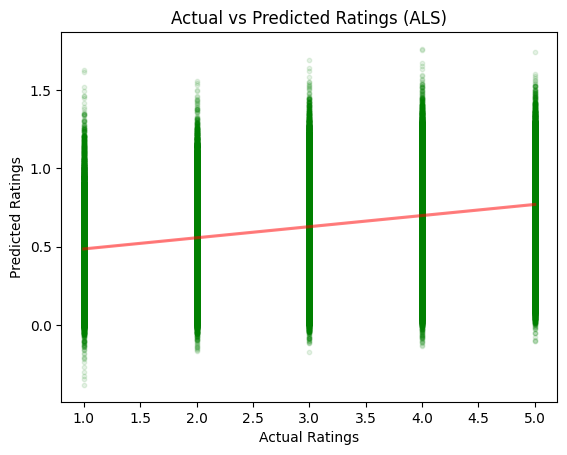

In [17]:
visualize_actual_vs_predicted(y_true, y_pred_als, "ALS")

# SVD

In [18]:
!pip install surprise

In [19]:
from surprise import SVD, accuracy

# Huấn luyện mô hình SVD
svd = SVD()
svd.fit(trainset)

# Dự đoán và đánh giá
predictions_svd = svd.test(testset)
y_pred_svd = [i.est for i in predictions_svd]
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)
mse_svd = accuracy.mse(predictions_svd)
results["SVD"] = {"RMSE": rmse_svd, "MAE": mae_svd, "MSE": mse_svd}
results["SVD"]

RMSE: 0.8757
MAE:  0.6872
MSE: 0.7669


{'RMSE': 0.8757245496386684,
 'MAE': 0.6872267472482142,
 'MSE': 0.7668934868398487}

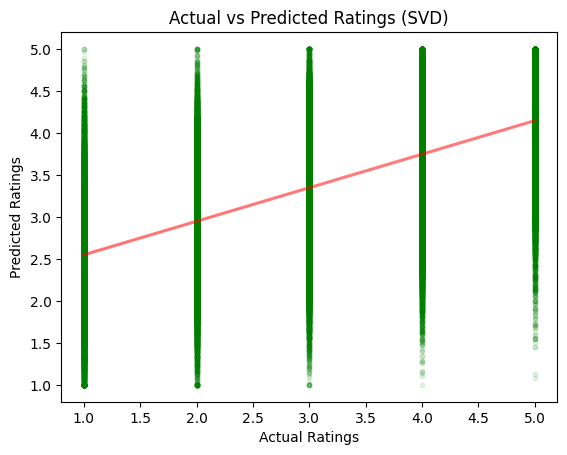

In [20]:
visualize_actual_vs_predicted(y_true, y_pred_svd, "SVD")

# NMF

In [21]:
from surprise import NMF

# Huấn luyện mô hình NMF
nmf = NMF()
nmf.fit(trainset)

# Dự đoán và đánh giá
predictions_nmf = nmf.test(testset)
y_pred_nmf = [i.est for i in predictions_nmf]
rmse_nmf = accuracy.rmse(predictions_nmf)
mae_nmf = accuracy.mae(predictions_nmf)
mse_nmf = accuracy.mse(predictions_nmf)
results["NMF"] = {"RMSE": rmse_nmf, "MAE": mae_nmf, "MSE": mse_nmf}
results["NMF"]

RMSE: 0.9156
MAE:  0.7239
MSE: 0.8384


{'RMSE': 0.9156199893382863,
 'MAE': 0.7239090586912048,
 'MSE': 0.8383599648758434}

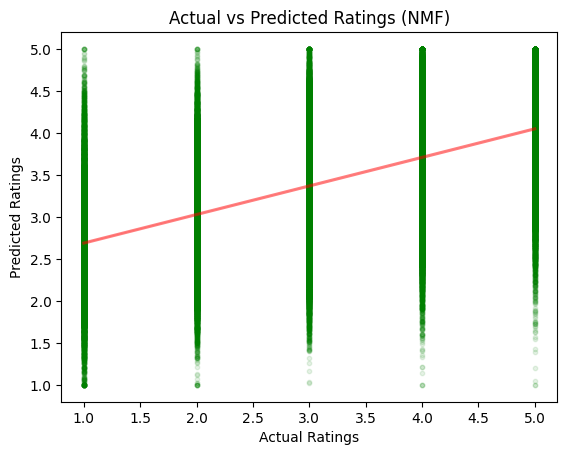

In [22]:
visualize_actual_vs_predicted(y_true, y_pred_nmf, "NMF")

#  BPR-MF (Bayesian Personalized Ranking Matrix Factorization)

In [23]:
from implicit.bpr import BayesianPersonalizedRanking

# Huấn luyện mô hình BPR-MF
bpr = BayesianPersonalizedRanking(factors=50, regularization=0.1)
bpr.fit(ratings_matrix)

# Dự đoán trên tập test
y_pred_bpr = [np.dot(bpr.user_factors[uid - 1], bpr.item_factors[iid - 1]) for uid, iid, _ in testset]

# Tính toán lỗi
rmse_bpr = math.sqrt(mean_squared_error(y_true, y_pred_bpr))
mae_bpr = mean_absolute_error(y_true, y_pred_bpr)
mse_bpr = mean_squared_error(y_true, y_pred_bpr)
results["BPR"] = {"RMSE": rmse_bpr, "MAE": mae_bpr, "MSE": mse_bpr}
results["BPR"]

  0%|          | 0/100 [00:00<?, ?it/s]

{'RMSE': 3.4669097751535807,
 'MAE': 3.2848435023630733,
 'MSE': 12.019463389055453}

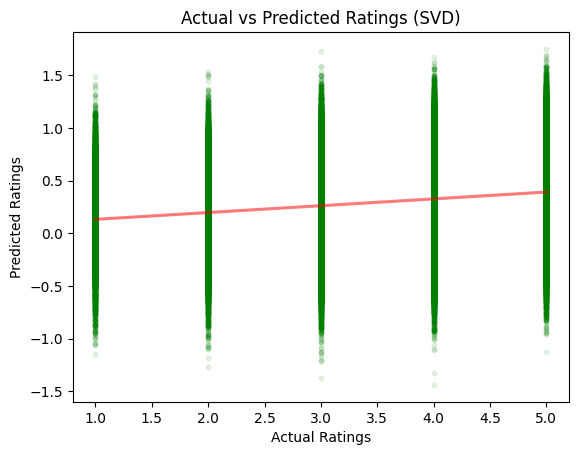

In [24]:
visualize_actual_vs_predicted(y_true, y_pred_bpr, "SVD")

# PMF

In [25]:
class PMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim=50, lambda_reg=0.1):
        super(PMF, self).__init__()
        self.user_factors = nn.Parameter(torch.randn(num_users, latent_dim) * 0.01)
        self.item_factors = nn.Parameter(torch.randn(num_items, latent_dim) * 0.01)
        self.lambda_reg = lambda_reg

    def forward(self, user_ids, item_ids):
        # Kiểm tra lỗi truy cập ngoài phạm vi
        if torch.any(user_ids >= self.user_factors.shape[0]) or torch.any(item_ids >= self.item_factors.shape[0]):
            raise IndexError("User or Item index out of bounds!")

        preds = (self.user_factors[user_ids] * self.item_factors[item_ids]).sum(dim=1)
        return preds

    def loss(self, preds, ratings):
        mse_loss = ((preds - ratings) ** 2).mean()
        reg_loss = self.lambda_reg * (self.user_factors.norm() + self.item_factors.norm())
        return mse_loss + reg_loss

In [27]:
from sklearn.model_selection import train_test_split

user_mapping = {id: idx for idx, id in enumerate(sorted(ratings_df["UserID"].unique()))}
item_mapping = {id: idx for idx, id in enumerate(sorted(ratings_df["MovieID"].unique()))}

ratings_df["UserID"] = ratings_df["UserID"].map(user_mapping)
ratings_df["MovieID"] = ratings_df["MovieID"].map(item_mapping)
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)
train_users = torch.tensor(train_df["UserID"].values, dtype=torch.long)
train_items = torch.tensor(train_df["MovieID"].values, dtype=torch.long)
train_ratings = torch.tensor(train_df["Rating"].values, dtype=torch.float32)

test_users = torch.tensor(test_df["UserID"].values, dtype=torch.long)
test_items = torch.tensor(test_df["MovieID"].values, dtype=torch.long)
test_ratings = torch.tensor(test_df["Rating"].values, dtype=torch.float32)
num_users = ratings_df["UserID"].nunique()
num_items = ratings_df["MovieID"].nunique()

print(f"Number of Users: {num_users}")
print(f"Number of Movies: {num_items}")
print(f"Max user index: {train_users.max()}, Expected max: {num_users-1}")
print(f"Max movie index: {train_items.max()}, Expected max: {num_items-1}")

Number of Users: 6040
Number of Movies: 3706
Max user index: 6039, Expected max: 6039
Max movie index: 3705, Expected max: 3705


In [28]:
pmf = PMF(num_users, num_items, latent_dim=20, lambda_reg=0.1)
optimizer = optim.SGD(pmf.parameters(), lr=0.3)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = pmf(train_users, train_items)  # Dự đoán
    loss = pmf.loss(preds, train_ratings)  # Tính loss
    loss.backward()
    optimizer.step()
    # print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

with torch.no_grad():
    test_preds = pmf(test_users, test_items).numpy()

rmse_pmf = np.sqrt(mean_squared_error(test_ratings, test_preds))
mae_pmf = mean_absolute_error(test_ratings, test_preds)
mse_pmf = mean_squared_error(test_ratings, test_preds)

# Lưu kết quả
results["PMF"] = {"RMSE": rmse_pmf, "MAE": mae_pmf, "MSE": mse_pmf}
results["PMF"]

{'RMSE': 3.7533474, 'MAE': 3.5824327, 'MSE': 14.087617}

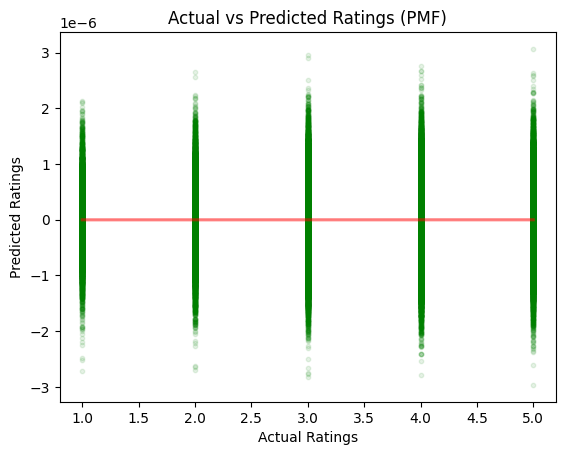

In [29]:
visualize_actual_vs_predicted(y_true, test_preds, "PMF")

### **Bảng So Sánh Các Phương Pháp Matrix Factorization**

| **Phương pháp** | **Công thức** | **Mô tả** | **Ưu điểm** | **Nhược điểm** | **Phù hợp cho** |
|---------------|-------------|---------|---------|-----------|--------------|
| **SVD** | $ R \approx U \Sigma V^T $ | Phân rã ma trận dựa trên Singular Value Decomposition. | Giảm nhiễu, trích xuất đặc trưng tốt. | Không phù hợp với dữ liệu thưa. | Dữ liệu có đủ đánh giá. |
| **ALS** | $ R \approx U V^T $ | Phân rã ma trận bằng phương pháp tối ưu luân phiên. | Xử lý dữ liệu thưa tốt, chạy song song. | Dễ bị overfitting. | Recommender trên hệ thống lớn. |
| **NMF** | $ R \approx W H $ | Phân rã ma trận với ràng buộc tất cả giá trị không âm. | Dễ diễn giải, không có giá trị âm. | Dễ bị local minima. | Phân tích chủ đề, dữ liệu phi âm. |
| **BPR-MF** | $ \max \sum_{(u, i, j) \in D} \log(\sigma(\hat{r}_{ui} - \hat{r}_{uj})) $ | Học thứ tự ưu tiên giữa các sản phẩm thay vì dự đoán giá trị chính xác. | Xử lý tốt implicit feedback. | Cần negative sampling. | Gợi ý sản phẩm, bài hát, phim. |
| **PMF** | $ p(R | U, V) = \prod_{u,i} N(R_{ui} | U_u^T V_i, \sigma^2)
$ | Mô hình xác suất sử dụng Bayesian Inference để tìm đặc trưng tiềm ẩn. | Khả năng tổng quát hóa cao. | Phức tạp, cần Bayesian Inference. | Gợi ý dựa trên mô hình xác suất. |
